# TEST 0

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from config import *
from common import *
display.clear_output()

In [3]:
from affwild2_challenge.basic_emotion.losses1 import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion.metrics import expr_score, f1_score, concordance_cc2

from affwild2_challenge.basic_emotion.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name
from affwild2_challenge.basic_emotion.dataload_expr_frames_v1 import FramesExprImageBalancedDataLoader
from affwild2_challenge.basic_emotion.datagen_expr_frames  import DataGenerator

from affwild2_challenge.basic_emotion.dataaug  import train_aug, valid_aug
from affwild2_challenge.basic_emotion.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input

from affwild2_challenge.basic_emotion.models.models_expr_frames import EXP_FRAMES_V0, EXP_VA_FRAMES_V0
from affwild2_challenge.basic_emotion.models.model_vggface2_ft import VGGFace2_AffWild2_V0

## 1. Setup Environments

In [4]:
params = {}
params["results_dir"] = os.path.join(sub_dir, "results", "t11")
params["db_file"] = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_aligned_frames.h5")
params["db_root"] = os.path.join(dataset_dir, "AffWild2/data/cropped_aligned")
params["batch_size"] = 32
params["gpus"] = ["-1"]
params["weights_path"] = os.path.join(sub_dir, "weights", "t11_affwild2_new_expr_frames_dynamic_vggface2_weights_200215192931_epoch-02_val_loss-0.41_val_acc-0.81.h5")
params["model_base_path"] = os.path.join(sub_dir, "weights", "rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5")

params["debug"] = False
params["run_train"] = False
params["run_valid"] = False
params["run_test"] = False

params["use_parallel_model"] = True
params["n_blocks"]  = 32
params["val_train"] = False
params["val_valid"] = True
params["max_queue_size"] = 16
params["workers"] = 8
params["use_multiprocessing"] = False

print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

if os.path.exists(params["results_dir"]) == False: os.makedirs(params["results_dir"])

parameters: 
+ results_dir: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/results/t11
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
+ batch_size: 32
+ gpus: ['-1']
+ weights_path: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/weights/t11_affwild2_new_expr_frames_dynamic_vggface2_weights_200215192931_epoch-02_val_loss-0.41_val_acc-0.81.h5
+ model_base_path: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit/weights/rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5
+ debug: False
+ run_train: False
+ run_valid: False
+ run_test: False
+ use_parallel_model: True
+ n_blocks: 32
+ val_train: False
+ val_valid: True
+ max_queue_size: 16
+ workers: 8
+ use_multiprocessing: False


In [5]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  -1
+ Keras backend:  tensorflow


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

TensorFlow Version: 1.15.0
No GPU found. Please use a GPU to train your neural network.


## 2. Setup Data

In [6]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)
ds.load_scheme_emotion()

dataset_info: 
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_aligned_frames.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped_aligned
Loading Scheme Emotion: 
 + Loading train: 251
 + Loading valid: 69
 + Loading test: 223


Number of images:	917835
Distribution:  {'Neutral': 583277, 'Angry': 23704, 'Disgust': 12588, 'Fear': 11155, 'Happy': 148100, 'Sad': 100174, 'Surprise': 38837}


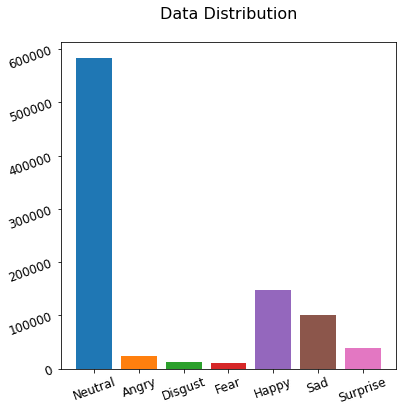

Number of images:	318503
Distribution:  {'Neutral': 182030, 'Angry': 7833, 'Disgust': 5709, 'Fear': 9734, 'Happy': 52064, 'Sad': 38070, 'Surprise': 23063}


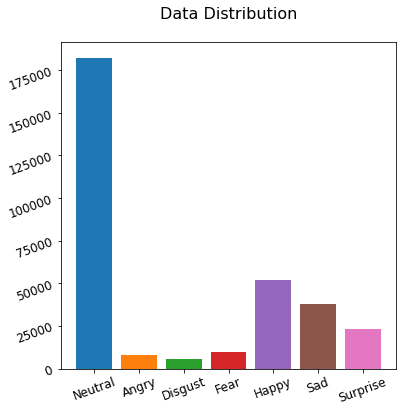

Number of images:	997332
Distribution:  {'Test': 997332}


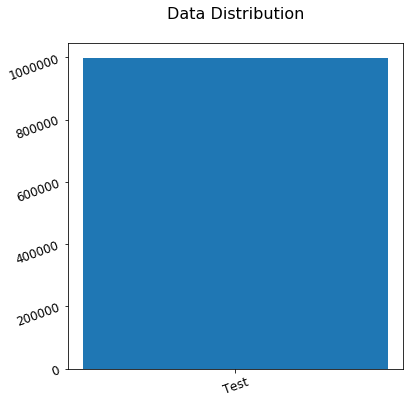

In [7]:
ds.view_emotion_summary(ds.a_idx_train, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_test, figsize=(6,6));

In [8]:
train_loader = FramesExprImageBalancedDataLoader(ds.a_idx_train, ds.a_scheme_train, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

valid_loader = FramesExprImageBalancedDataLoader(ds.a_idx_valid, ds.a_scheme_valid, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_loader = FramesExprImageBalancedDataLoader(ds.a_idx_test, ds.a_scheme_test, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

(224, 224, 3) (32, 224, 224, 3) (7,)
(224, 224, 3) (32, 224, 224, 3) (7,)
(224, 224, 3) (32, 224, 224, 3) None
Training
View 3D Images: Emotion = Happy


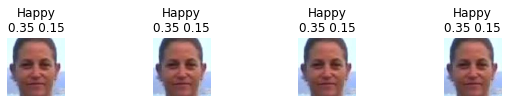

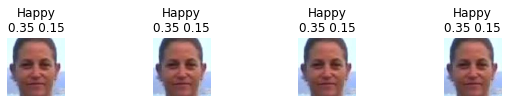

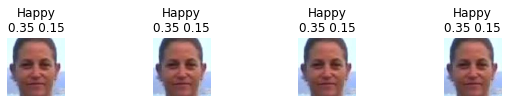

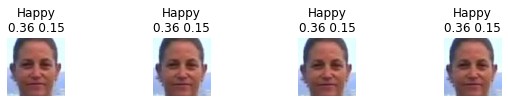

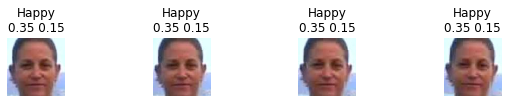

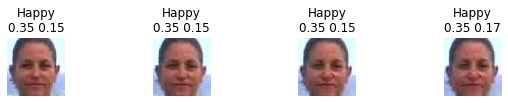

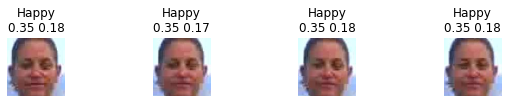

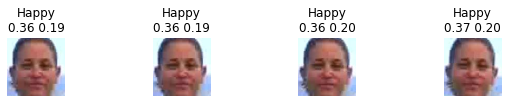

Validating
View 3D Images: Emotion = Neutral


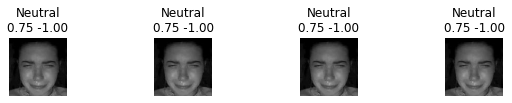

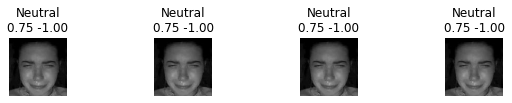

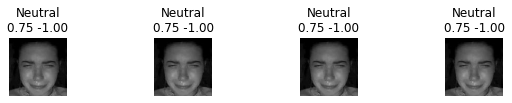

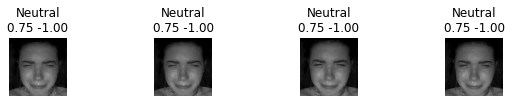

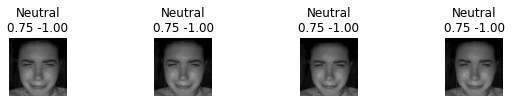

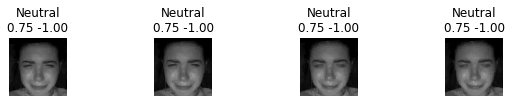

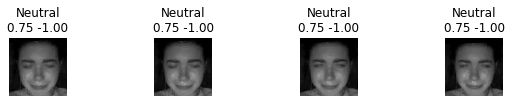

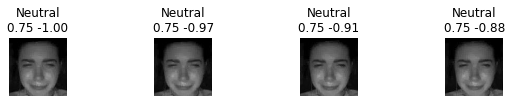

Testing
View 3D Images: Emotion = Unknown


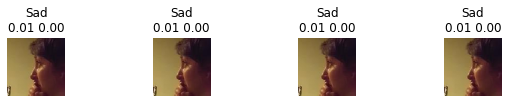

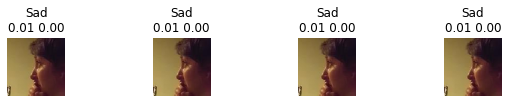

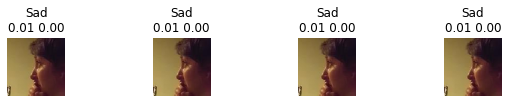

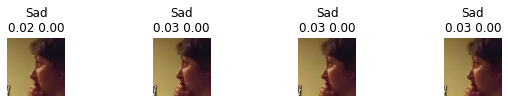

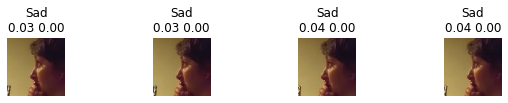

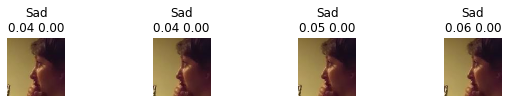

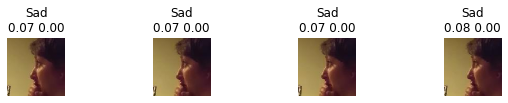

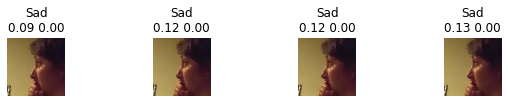

In [9]:
x, y = train_loader[20]
print(x[0].shape, x[1].shape, y.shape)
x, y = valid_loader[20]
print(x[0].shape, x[1].shape, y.shape)
x, y = test_loader[20]
print(x[0].shape, x[1].shape, y)

print("Training")
train_loader.view_image(20, cols = 4)
print("Validating")
valid_loader.view_image(20, cols = 4)
print("Testing")
test_loader.view_image(20, cols = 4)

In [10]:
train_gen = DataGenerator(dataloader = train_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Train: ")
x, y = next(train_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y.shape)

valid_gen = DataGenerator(dataloader = valid_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Valid: ")
x, y = next(valid_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y.shape)

test_gen = DataGenerator(dataloader = test_loader, 
                         has_dynamic_blocks = False,
                         dynamic_blocks = [4, 8, 16, 32],
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test: ")
x, y = next(test_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y)

Train: 
(32, 224, 224, 3) -111.0912 163.5047
(32, 32, 224, 224, 3) -111.0912 163.5047
(32, 7)
Valid: 
(32, 224, 224, 3) -131.0912 79.5047
(32, 32, 224, 224, 3) -131.0912 79.5047
(32, 7)
Test: 
(32, 224, 224, 3) -115.0912 149.11731
(32, 32, 224, 224, 3) -115.0912 149.11731
None


## 3. Setup Model

In [11]:
if params["run_train"]==True or params["run_valid"]==True or params["run_test"]==True:
    # Load model VGGFace
    K.clear_session()
    model_base = VGGFace2_AffWild2_V0(nb_classes = 7,dropout = [0.0, 0.0])
    model_base.load_weights(params["model_base_path"])
        
    # Summary
    model_base.summary()
        
    # Free_weights for fine-tuning
    idx_predictions = -1
    idx_features = -1
    idx_conv = -1

    layer_predictions_name = "predictions"
    layer_conv_name = "conv4_1_1x1_reduce"
    layer_feature_name = "features"

    for idx in range(len(model_base.layers)):
        if model_base.layers[idx].name == layer_feature_name: # features, 
            idx_features = idx
        elif model_base.layers[idx].name == layer_conv_name: # conv4_1_1x1_reduce
            idx_conv = idx
        elif model_base.layers[idx].name == layer_predictions_name: # conv4_1_1x1_reduce
            idx_predictions = idx

    for idx in range(len(model_base.layers)):
        if idx<idx_conv:
            model_base.layers[idx].trainable = False
        else:
            model_base.layers[idx].trainable = True
    # for

    print(idx_features)
    print(idx_conv)
    print(idx_predictions)

    model_base_fea = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_features].output)
    model_base_pre = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_predictions].output)
        
    # Load model
    model_config = dict(
        model_base_fea = model_base_fea, 
        model_base_pre = model_base_pre, 
        nb_classes = 7, 
        fc_finals = [1024, 1024], 
        fc_dropout = [0.1, 0.1, 0.1]
    )
    model = EXP_FRAMES_V0(**model_config)

    # Load Weights
    print(params["weights_path"])
    model.load_weights(params["weights_path"])

    # Model Summary
    model.summary()

    if params["use_parallel_model"] == True:
        model = multi_gpu_model(model, gpus = len(params["gpus"]))
    # if
# if

## 4. Predict

### 4.1. Train

In [12]:
if params["run_train"] == True:
    train_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(train_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    else:
        y_pred = model.predict(train_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    # if
# if

In [13]:
if params["run_train"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    print(f"Save Train: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.2. Valid

In [14]:
if params["run_valid"] == True:
    valid_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(valid_gen, steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(valid_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

In [15]:
if params["run_valid"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    print(f"Save Valid: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.3. Test

In [16]:
if params["run_test"] == True:    
    test_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_gen, 
                               steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(test_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
# if

In [17]:
if params["run_test"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"test_{params['n_blocks']}.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

## 5. Evaluation

### 5.1. Train

In [18]:
if params["val_train"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_train

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
# if

## 5.2. Valid

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.78      0.44      0.56    182030
       Angry       0.09      0.22      0.13      7833
     Disgust       0.13      0.09      0.10      5709
        Fear       0.09      0.27      0.13      9734
       Happy       0.52      0.64      0.58     52064
         Sad       0.37      0.52      0.43     38070
    Surprise       0.24      0.47      0.31     23063

    accuracy                           0.47    318503
   macro avg       0.32      0.38      0.32    318503
weighted avg       0.60      0.47      0.50    318503

Confustion Matrix Int: 
 [[79784 13413  1805 17339 24496 18298 26895]
 [  965  1705   155   586  1304  2256   862]
 [  725   225   492    54   548  3491   174]
 [ 2934   627   641  2599   130  1873   930]
 [ 5849  1427   283   855 33565  5790  4295]
 [ 9048  1191   154  4633  1901 19621  1522]
 [ 3192   717   224  4060  2672  1430 10768]]

Confustion Matrix Norm: 
 [[43.83  7

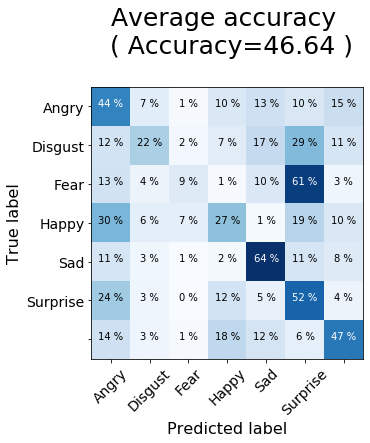

In [19]:
if params["val_valid"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_valid

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
# if